## Helper Methods and Imports

In [0]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import fetch_lfw_people, fetch_olivetti_faces
from scipy import linalg
from random import uniform
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import cv2
import bz2
from random import uniform
from skimage import transform


In [2]:
# Mount directories
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
# import my utility functions
import sys
sys.path.append('/content/gdrive/Shared With Me/CSCI1430_Final_Project/')
from zipfile import ZipFile
from PIL import Image

In [0]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import linalg
from random import uniform



"""
Shows 15 images in the given dataset
"""
def show_images_in_dataset(dataset, cmap=plt.cm.bone):
  fig = plt.figure(figsize=(10,5))
  for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(dataset[i], cmap=cmap)

"""These are the two PCA methods"""

def compute_PCA_covariance_method(data, num_components, greyscale=True):
  if(greyscale):
    n, m = data.shape
  else:
    n, m, _ = data.shape
  # Calculate the empirical mean
  mean_face = np.mean(data, axis=0)
  # Calculate the deviations from the mean
  B = data - mean_face
  # Find the covariance matrix, there's two ways of doing it
  C = np.cov(B, rowvar=False)
  C = np.dot(B.T, B) / (n-1) # alternate way
  # Find the eigenvectors and the eigenvalues of the covariance matrix
  eigenvals, eigenvecs = linalg.eigh(C)
  # Rearrange the eigenvectors and eigenvalues, Sort the columns of the eigenvector matrix V and eigenvalue matrix D in order of decreasing eigenvalue.
  idx = np.argsort(eigenvals)[::-1]
  eigenvecs = eigenvecs[:,idx]
  eigenvals = eigenvals[idx]
  # Select a subset of the eigenvectors as basis vectors
  eigenvecs = eigenvecs[:, :num_components]
  # Project the z-scores of the data onto the new basis
  data_pca = np.dot(B, eigenvecs)
  return data_pca, eigenvecs.T, eigenvals, mean_face


"""
Apparently PCA which uses SVD in the backend is more computationally efficient
than PCA using covariance
"""
def pca_using_svd(data, num_components):
  # calculate mean
  mean_face = np.mean(data, axis=0)

  # center data
  data = data - mean_face

  # SVD on centered data
  U, S, V = np.linalg.svd(data)

  reduced_u = U[:,:num_components]
  reduced_s = S[:num_components]
  reduced_v = V[:num_components]

  return data, reduced_v, reduced_s, mean_face

""" Linear Discriminant Analysis """

def lda (data, labels, num_components):
  # get the shape of the data
  n, m = data.shape

  # get the classes the data separates into
  classes = np.unique(labels)

  # ensure the number of components is at most # of labels - 1
  if num_components > (len(classes) - 1):
    num_components = (len(classes) - 1)
  
  # get mean
  mean = np.mean(data, axis=0)

  # Initialize our scatter matrices for the LDA
  scatter_matrix_w = np.zeros((m, m))
  scatter_matrix_b = np.zeros((m, m))


  # for each label...
  for label in classes:
    
    # get the data that corresponds to that label
    class_data = data[np.where(labels == label) [0], :]

    # get the mean
    class_mean = np.mean(class_data, axis=0)

    # subtracting the class mean from the class data
    zero_mean_class_data = class_data - class_mean

    # getting the difference between the class mean and the total mean
    mean_difference = class_mean - mean

    # updating our scatter matrices
    scatter_matrix_w += np.dot(zero_mean_class_data.T , zero_mean_class_data)
    scatter_matrix_b += n * np.dot(mean_difference.T , mean_difference)

  # get the eigenvalues and eigenvectors (can't use SVD since we don't know if SW^-1 * SB is symmetric)
  eigenvals, eigenvecs = np.linalg.eigh(np.linalg.inv(scatter_matrix_w) * scatter_matrix_b)

  # sort the eigenvectors and values to get the vectors with the largest values
  idx = np.argsort(eigenvals)[::-1]
  eigenvecs = eigenvecs[:,idx]
  eigenvals = eigenvals[idx]

  # only use a subset of the eigenvectors based on how many components we want to use.
  eigenvecs = eigenvecs[:, :num_components]
  

  return data, eigenvecs, eigenvals


""" fisherfaces method using lda and pca """
def fisherfaces(data, labels, num_components):
  
  # get the shape of the data
  n, m = data.shape

  # get the number of unique classes
  num_classes = len(np.unique(labels))

  # run pca on the dataset
  data_pca, eigenvecs_pca, eigenvals_pca, mean_pca = pca_using_svd(data, num_components)
  # run lda on the projection of the data into the eigenvector space
  data_lda, eigenvecs_lda, eigenvals_lda = lda(np.dot(data_pca, eigenvecs_pca.T), labels, num_components)

  # the fishervectors then become the dot product of the eigenvectors produced
  # by pca and lda
  eigenvectors = np.dot(eigenvecs_pca.T, eigenvecs_lda)

  return eigenvectors.T, eigenvals_lda, mean_pca


"""
Method to reconstruct a face
"""
def reconstruct_face(face_to_reconstruct, mean_face, eigenvectors):
  # vectorize image
  face_vector = face_to_reconstruct.reshape(-1)
 # subtract mean vector
  face_vector = face_vector - mean_face.reshape(-1)
 # project onto principal components, which means dot product of face to reconstruct with each eigenvector
  weights = np.dot(face_vector, eigenvectors.T)
  # assemble face vector by summing average face with weighted components
  new_vec = mean_face.reshape(-1)
  # each weight * each component + average face
  new_vec = new_vec + np.dot(weights, eigenvectors)
  # reshape vector into facial image
  reconstructed_face = np.reshape(new_vec, (face_to_reconstruct.shape))
  
  return reconstructed_face


## Training On LFW

In [0]:
# using 250 components to properly compare with eigenfaces
num_components = 250

# get the lfw dataset
lfw = fetch_lfw_people(min_faces_per_person=10)
labels = lfw.target
lfw_faces = lfw.images

lfw_faces_resized = np.zeros((len(lfw_faces), 64, 64))

# resize the images to 64x64
for i in range(len(lfw_faces)):
  face = lfw_faces[i]
  lfw_faces_resized[i] = cv2.resize(face, dsize=(64,64))

lfw_faces = lfw_faces_resized


num_images, height, width = lfw_faces.shape

face_data = lfw_faces.reshape(num_images, height*width)

num_classes = len(np.unique(labels))

mean_face = np.mean(face_data, axis=0)

fisher_array = fisherfaces(face_data, labels, num_components)
fishervecs = fisher_array[0]
fishervals = fisher_array[1]
fisherface_array = fishervecs.reshape((num_classes - 1, height, width))

These are the top 15 fisherfaces ordered by how much variation they have (correspond to largest eigenvalues)


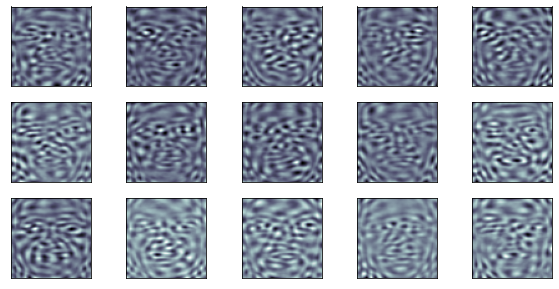

In [6]:
# Shows 15 of the eigenfaces in the dataset
show_images_in_dataset(fisherface_array)
print("These are the top 15 fisherfaces ordered by how much variation they have \
(correspond to largest eigenvalues)")

In [0]:
# get the olivetti dataset
olivetti = fetch_olivetti_faces()
# get the labels, images, and average face
labels = olivetti.target
olivetti_faces = olivetti.images
mean_face = np.mean(olivetti_faces, axis=0)

# project the olivetti images into the fisherfaces space
olivetti_projections = np.dot((olivetti_faces.reshape(400, -1) - mean_face.reshape(-1)), fishervecs.T)

# number of components to take
component_list = [1,2,4,8,16,32,64, 128, 250]

# number of images per person to train on 
percent_train_list = [i+1 for i in range(9)]

# initialize a matrix to store accuracy values
accuracy_mat = np.zeros((len(component_list), len(percent_train_list)+1))

# for 10 random states
for r in range(10):

  # for each number of components
  for c_idx in range(len(component_list)):

    # get the number of components to use
    c = component_list[c_idx]

    # get a slice of the projected images as big as the # of components
    olive = olivetti_projections[:, :c]

    # train test split, using different amounts of images, from 1 to 9.
    for train_amount in percent_train_list:
      X_train, X_test, y_train, y_test = train_test_split(olive \
      , labels, test_size=(1-train_amount/10), random_state=r, stratify=labels)

      # Use nearest neighbor to classify
      knn = KNeighborsClassifier(n_neighbors=1)

      # fit our model
      knn.fit(X_train, y_train)
      # test its accuracy
      acc = knn.score(X_test, y_test)
      # add the accuracy to our matrix
      accuracy_mat[c_idx, train_amount] += acc
      
# divide the matrix by the number of random iterations
accuracy_mat = accuracy_mat/10

Maximum Accuracy Achieved: 0.8724999999999999


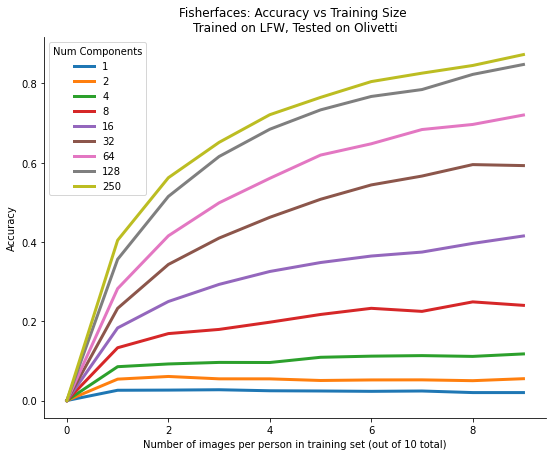

In [8]:
print("Maximum Accuracy Achieved: " + str(np.max(accuracy_mat)))

plt.figure(figsize=(9,7))

labels = [str(i) for i in component_list]
plt.plot(accuracy_mat.T, lw=3)
plt.legend(labels, title="Num Components")
plt.xlabel('Number of images per person in training set (out of 10 total)')
plt.ylabel('Accuracy')
plt.title('Fisherfaces: Accuracy vs Training Size \nTrained on LFW, Tested on Olivetti')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [0]:
# get the simpsons images
simpsons_path = "/content/gdrive/My Drive/CSCI1430_Final_Project/Data/simpsons_labeled.zip"

# initialize arrays for labels and the images
simpsons_array = []
labels = []

# Enter the file
with ZipFile(simpsons_path) as archive:
    for entry in archive.infolist():
        with archive.open(entry) as file:

            # append the proper label to the labels array
            labels.append(file.name.split('/')[1].split('_')[0])
            
            # preprocess the image to make it 64x64 and greyscale
            img = Image.open(file).convert("L")
            img = np.asarray(img)
            img = transform.resize(img, (64,64))

            # append it to the image array
            simpsons_array.append(img)

# we only need one of each label, instead of the 11 duplicates of each
labels = np.unique(labels, return_inverse=True)[1]

simpsons_array = np.asarray(simpsons_array)

# store the parameters based on the dataset
num_images, height, width = simpsons_array.shape
face_data = simpsons_array.reshape(num_images, height*width)

mean_face = np.mean(face_data, axis=0)

In [0]:
# project the simpsons images into the fisherfaces space
cartoon_projections = np.dot((simpsons_array.reshape(550, -1) - mean_face.reshape(-1)), fishervecs.T)

# number of components to take
component_list = [1,2,4,8,16,32,64, 128, 250]

# number of images per person to train on 
percent_train_list = [i+1 for i in range(9)]

# initialize a matrix to store accuracy values
accuracy_mat = np.zeros((len(component_list), len(percent_train_list)+1))

# for 10 random states
for r in range(10):

  # for each number of components
  for c_idx in range(len(component_list)):

    # get the number of components to use
    c = component_list[c_idx]

    # get a slice of the projected images as big as the # of components
    olive = cartoon_projections[:, :c]

    # train test split, using different amounts of images, from 1 to 9.
    for train_amount in percent_train_list:
      X_train, X_test, y_train, y_test = train_test_split(olive \
      , labels, test_size=(1-train_amount/10), random_state=r, stratify=labels)

      # Use nearest neighbor to classify
      knn = KNeighborsClassifier(n_neighbors=1)

      # fit our model
      knn.fit(X_train, y_train)
      # test its accuracy
      acc = knn.score(X_test, y_test)
      # add the accuracy to our matrix
      accuracy_mat[c_idx, train_amount] += acc
      
# divide the matrix by the number of random iterations
accuracy_mat = accuracy_mat/10

Maximum Accuracy Achieved: 0.5654545454545454


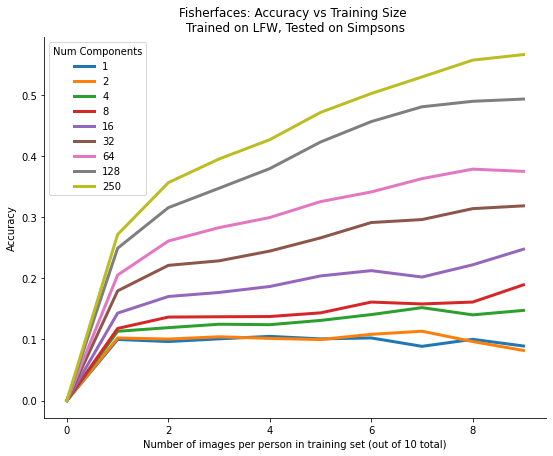

In [11]:
print("Maximum Accuracy Achieved: " + str(np.max(accuracy_mat)))

plt.figure(figsize=(9,7))

labels = [str(i) for i in component_list]
plt.plot(accuracy_mat.T, lw=3)
plt.legend(labels, title="Num Components")
plt.xlabel('Number of images per person in training set (out of 10 total)')
plt.ylabel('Accuracy')
plt.title('Fisherfaces: Accuracy vs Training Size \nTrained on LFW, Tested on Simpsons')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

## Training on Yale Face Database

(2452, 64, 64)
(2452,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]


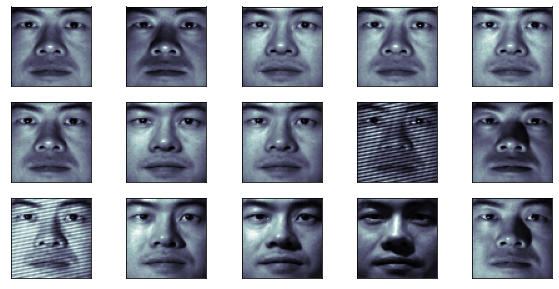

In [12]:
# Getting Yale Face Database!

yale_path = "/content/gdrive/My Drive/CSCI1430_Final_Project/Data/yalefaces_cropped.zip"

yale_array = []
yale_labels = []

with ZipFile(yale_path) as archive:
    for entry in archive.infolist():
        with archive.open(entry) as file:
            yale_labels.append(file.name.split('/')[1].split('B')[1][:2])
            img = Image.open(file)
            img = np.asarray(img)
            yale_array.append(img)

yale_labels = np.unique(yale_labels, return_inverse=True)[1]

yale_array = np.asarray(yale_array)

yale_faces_resized = np.zeros((len(yale_array), 64, 64))

# resize the images to 64x64
for i in range(len(yale_array)):
  face = yale_array[i]
  yale_faces_resized[i] = cv2.resize(face, dsize=(64,64))

yale_array = yale_faces_resized

show_images_in_dataset(yale_array[70:100])

print(yale_array.shape)
print(yale_labels.shape)
print(np.unique(yale_labels))

In [0]:
# using 250 components to properly compare with eigenfaces
num_components = 250

# set parameters for the dataset
num_images, height, width = yale_array.shape

face_data = yale_array.reshape(num_images, height*width)

labels  = yale_labels

num_classes = len(np.unique(labels))

mean_face = np.mean(face_data, axis=0)
  
num_classes = len(np.unique(labels))
fisher_array = fisherfaces(face_data, labels, num_components)
fishervecs = fisher_array[0]
fishervals = fisher_array[1]
fisherface_array = fishervecs.reshape((num_classes - 1, height, width))

These are the top 15 fisherfaces ordered by how much variation they have (correspond to largest eigenvalues)


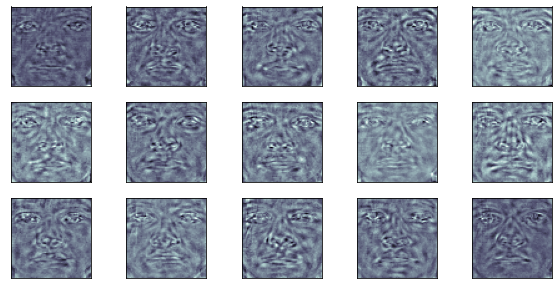

In [14]:
# Shows 15 of the eigenfaces in the dataset
show_images_in_dataset(fisherface_array)
print("These are the top 15 fisherfaces ordered by how much variation they have \
(correspond to largest eigenvalues)")

In [0]:
# get the olivetti dataset
olivetti = fetch_olivetti_faces()
# get the labels, images, and average face
labels = olivetti.target
olivetti_faces = olivetti.images
mean_face = np.mean(olivetti_faces, axis=0)

# project the olivetti images into the fisherfaces space
olivetti_projections = np.dot((olivetti_faces.reshape(400, -1) - mean_face.reshape(-1)), fishervecs.T)

# number of components to take
component_list = [1,2,4,8,16,32,64, 128, 250]

# number of images per person to train on 
percent_train_list = [i+1 for i in range(9)]

# initialize a matrix to store accuracy values
accuracy_mat = np.zeros((len(component_list), len(percent_train_list)+1))

# for 10 random states
for r in range(10):

  # for each number of components
  for c_idx in range(len(component_list)):

    # get the number of components to use
    c = component_list[c_idx]

    # get a slice of the projected images as big as the # of components
    olive = olivetti_projections[:, :c]

    # train test split, using different amounts of images, from 1 to 9.
    for train_amount in percent_train_list:
      X_train, X_test, y_train, y_test = train_test_split(olive \
      , labels, test_size=(1-train_amount/10), random_state=r, stratify=labels)

      # Use nearest neighbor to classify
      knn = KNeighborsClassifier(n_neighbors=1)

      # fit our model
      knn.fit(X_train, y_train)
      # test its accuracy
      acc = knn.score(X_test, y_test)
      # add the accuracy to our matrix
      accuracy_mat[c_idx, train_amount] += acc
      
# divide the matrix by the number of random iterations
accuracy_mat = accuracy_mat/10

Maximum Accuracy Achieved: 0.7749999999999999


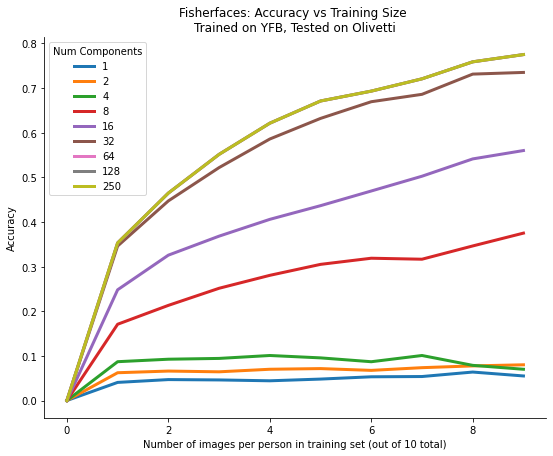

In [16]:
print("Maximum Accuracy Achieved: " + str(np.max(accuracy_mat)))

plt.figure(figsize=(9,7))

labels = [str(i) for i in component_list]
plt.plot(accuracy_mat.T, lw=3)
plt.legend(labels, title="Num Components")
plt.xlabel('Number of images per person in training set (out of 10 total)')
plt.ylabel('Accuracy')
plt.title('Fisherfaces: Accuracy vs Training Size \nTrained on YFB, Tested on Olivetti')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [0]:
# get the simpsons images
simpsons_path = "/content/gdrive/My Drive/CSCI1430_Final_Project/Data/simpsons_labeled.zip"

# initialize arrays for labels and the images
simpsons_array = []
labels = []

# Enter the file
with ZipFile(simpsons_path) as archive:
    for entry in archive.infolist():
        with archive.open(entry) as file:

            # append the proper label to the labels array
            labels.append(file.name.split('/')[1].split('_')[0])
            
            # preprocess the image to make it 64x64 and greyscale
            img = Image.open(file).convert("L")
            img = np.asarray(img)
            img = transform.resize(img, (64,64))

            # append it to the image array
            simpsons_array.append(img)

# we only need one of each label, instead of the 11 duplicates of each
labels = np.unique(labels, return_inverse=True)[1]

simpsons_array = np.asarray(simpsons_array)

# store the parameters based on the dataset
num_images, height, width = simpsons_array.shape
face_data = simpsons_array.reshape(num_images, height*width)

mean_face = np.mean(face_data, axis=0)

In [0]:
# project the simpsons images into the fisherfaces space
cartoon_projections = np.dot((simpsons_array.reshape(550, -1) - mean_face.reshape(-1)), fishervecs.T)

# number of components to take
component_list = [1,2,4,8,16,32,64, 128, 250]

# number of images per person to train on 
percent_train_list = [i+1 for i in range(9)]

# initialize a matrix to store accuracy values
accuracy_mat = np.zeros((len(component_list), len(percent_train_list)+1))

# for 10 random states
for r in range(10):

  # for each number of components
  for c_idx in range(len(component_list)):

    # get the number of components to use
    c = component_list[c_idx]

    # get a slice of the projected images as big as the # of components
    olive = cartoon_projections[:, :c]

    # train test split, using different amounts of images, from 1 to 9.
    for train_amount in percent_train_list:
      X_train, X_test, y_train, y_test = train_test_split(olive \
      , labels, test_size=(1-train_amount/10), random_state=r, stratify=labels)

      # Use nearest neighbor to classify
      knn = KNeighborsClassifier(n_neighbors=1)

      # fit our model
      knn.fit(X_train, y_train)
      # test its accuracy
      acc = knn.score(X_test, y_test)
      # add the accuracy to our matrix
      accuracy_mat[c_idx, train_amount] += acc
      
# divide the matrix by the number of random iterations
accuracy_mat = accuracy_mat/10

Maximum Accuracy Achieved: 0.44727272727272727


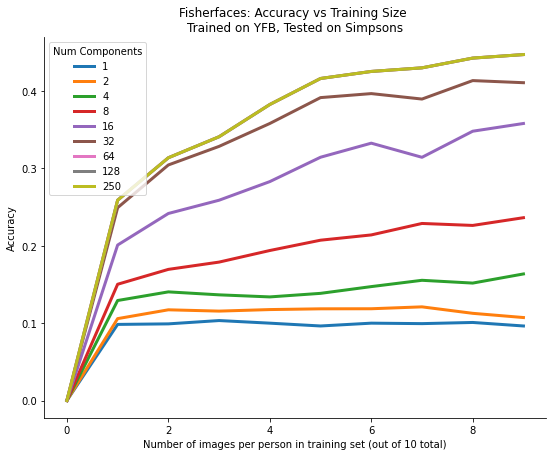

In [19]:
print("Maximum Accuracy Achieved: " + str(np.max(accuracy_mat)))

plt.figure(figsize=(9,7))

labels = [str(i) for i in component_list]
plt.plot(accuracy_mat.T, lw=3)
plt.legend(labels, title="Num Components")
plt.xlabel('Number of images per person in training set (out of 10 total)')
plt.ylabel('Accuracy')
plt.title('Fisherfaces: Accuracy vs Training Size \nTrained on YFB, Tested on Simpsons')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

## Training On Simpsons Dataset

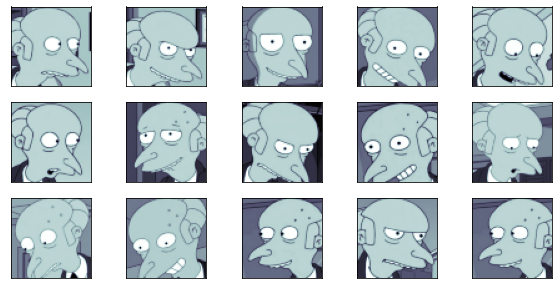

In [20]:
# get the simpsons images
simpsons_path = "/content/gdrive/My Drive/CSCI1430_Final_Project/Data/simpsons_labeled.zip"

# initialize arrays for labels and the images
simpsons_array = []
labels = []

# Enter the file
with ZipFile(simpsons_path) as archive:
    for entry in archive.infolist():
        with archive.open(entry) as file:

            # append the proper label to the labels array
            labels.append(file.name.split('/')[1].split('_')[0])
            
            # preprocess the image to make it 64x64 and greyscale
            img = Image.open(file).convert("L")
            img = np.asarray(img)
            img = transform.resize(img, (64,64))

            # append it to the image array
            simpsons_array.append(img)

# we only need one of each label, instead of the 11 duplicates of each
labels = np.unique(labels, return_inverse=True)[1]

simpsons_array = np.asarray(simpsons_array)

# store the parameters based on the dataset
num_images, height, width = simpsons_array.shape
face_data = simpsons_array.reshape(num_images, height*width)

show_images_in_dataset(simpsons_array[70:100])

mean_face = np.mean(face_data, axis=0)


In [0]:
# using 250 components in order to properly compare to eigenfaces
num_components = 250

num_images, height, width = simpsons_array.shape
face_data = simpsons_array.reshape(num_images, height*width)
mean_face = np.mean(face_data, axis=0)
  
num_classes = len(np.unique(labels))
fisher_array = fisherfaces(face_data, labels, num_components)
fishervecs = fisher_array[0]
fishervals = fisher_array[1]
fisherface_array = fishervecs.reshape((num_classes - 1, height, width))

In [0]:
# project the simpsons images into the fisherfaces space
cartoon_projections = np.dot((simpsons_array.reshape(550, -1) - mean_face.reshape(-1)), fishervecs.T)

# number of components to take
component_list = [1,2,4,8,16,32,64, 128, 250]

# number of images per person to train on 
percent_train_list = [i+1 for i in range(9)]

# initialize a matrix to store accuracy values
accuracy_mat = np.zeros((len(component_list), len(percent_train_list)+1))

# for 10 random states
for r in range(10):

  # for each number of components
  for c_idx in range(len(component_list)):

    # get the number of components to use
    c = component_list[c_idx]

    # get a slice of the projected images as big as the # of components
    olive = cartoon_projections[:, :c]

    # train test split, using different amounts of images, from 1 to 9.
    for train_amount in percent_train_list:
      X_train, X_test, y_train, y_test = train_test_split(olive \
      , labels, test_size=(1-train_amount/10), random_state=r, stratify=labels)

      # Use nearest neighbor to classify
      knn = KNeighborsClassifier(n_neighbors=1)

      # fit our model
      knn.fit(X_train, y_train)
      # test its accuracy
      acc = knn.score(X_test, y_test)
      # add the accuracy to our matrix
      accuracy_mat[c_idx, train_amount] += acc
      
# divide the matrix by the number of random iterations
accuracy_mat = accuracy_mat/10

Maximum Accuracy Achieved: 0.9753012048192771


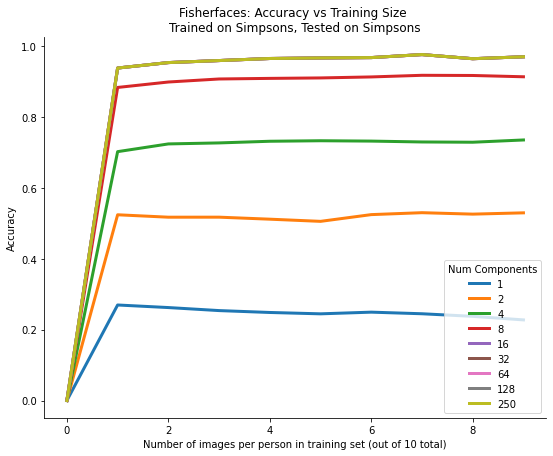

In [23]:
print("Maximum Accuracy Achieved: " + str(np.max(accuracy_mat)))

plt.figure(figsize=(9,7))

labels = [str(i) for i in component_list]
plt.plot(accuracy_mat.T, lw=3)
plt.legend(labels, title="Num Components")
plt.xlabel('Number of images per person in training set (out of 10 total)')
plt.ylabel('Accuracy')
plt.title('Fisherfaces: Accuracy vs Training Size \nTrained on Simpsons, Tested on Simpsons')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [0]:
# get the olivetti dataset
olivetti = fetch_olivetti_faces()
# get the labels, images, and average face
labels = olivetti.target
olivetti_faces = olivetti.images
mean_face = np.mean(olivetti_faces, axis=0)

# project the olivetti images into the fisherfaces space
olivetti_projections = np.dot((olivetti_faces.reshape(400, -1) - mean_face.reshape(-1)), fishervecs.T)

# number of components to take
component_list = [1,2,4,8,16,32,64, 128, 250]

# number of images per person to train on 
percent_train_list = [i+1 for i in range(9)]

# initialize a matrix to store accuracy values
accuracy_mat = np.zeros((len(component_list), len(percent_train_list)+1))

# for 10 random states
for r in range(10):

  # for each number of components
  for c_idx in range(len(component_list)):

    # get the number of components to use
    c = component_list[c_idx]

    # get a slice of the projected images as big as the # of components
    olive = olivetti_projections[:, :c]

    # train test split, using different amounts of images, from 1 to 9.
    for train_amount in percent_train_list:
      X_train, X_test, y_train, y_test = train_test_split(olive \
      , labels, test_size=(1-train_amount/10), random_state=r, stratify=labels)

      # Use nearest neighbor to classify
      knn = KNeighborsClassifier(n_neighbors=1)

      # fit our model
      knn.fit(X_train, y_train)
      # test its accuracy
      acc = knn.score(X_test, y_test)
      # add the accuracy to our matrix
      accuracy_mat[c_idx, train_amount] += acc
      
# divide the matrix by the number of random iterations
accuracy_mat = accuracy_mat/10

Maximum Accuracy Achieved: 0.61


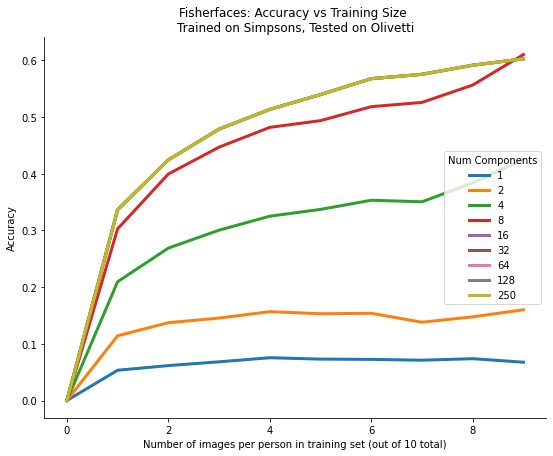

In [25]:
print("Maximum Accuracy Achieved: " + str(np.max(accuracy_mat)))

plt.figure(figsize=(9,7))

labels = [str(i) for i in component_list]
plt.plot(accuracy_mat.T, lw=3)
plt.legend(labels, title="Num Components")
plt.xlabel('Number of images per person in training set (out of 10 total)')
plt.ylabel('Accuracy')
plt.title('Fisherfaces: Accuracy vs Training Size \nTrained on Simpsons, Tested on Olivetti')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)